# [팀프로젝트] 원티드 DB 국민연금 사업장 데이터로 유니콘 기업 찾기 🦄

## 🗂 데이터 정보
- 회사 수 : 5,000개
- 월별 데이터 : 직원 수, 국민연금 보험료 (인원 수에 대한 상한선_최대 고지금액이 존재함)
- 년 단위 데이터 : 매출액 (천원 단위)

## 📊 EDA 목표
- 위 데이터들의 분포 (직원 수, 매출액, 보험료 + @)
- 몇몇 회사를 선택하여 데이터 흐름 살펴보기
- 데이터 사이의 관계에 대한 유의미한 결론 (가설 설정 -> 검증)

## 🔧 개요
1. 데이터 탐색(EDA)
2. 유니콘 기업을 어떻게 정의할 것인가?
3. (기준에 따른) 데이터 분석, 유니콘 찾기
4. 결론

### 🔎  1. 데이터  탐색

In [15]:
import pandas as pd
import numpy as np

from matplotlib import rcParams
from matplotlib import font_manager, rc
import seaborn as sns
import platform
import matplotlib.pyplot as plt
from datetime import datetime

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='NanumGothic')
plt.rc('font', family='NanumBarunGothic') 


In [2]:
df = pd.read_csv('company_nps_data.csv', encoding='cp949')
df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151


In [3]:
# 결측치 확인
df.isna().sum()

회사ID        0
연매출액        0
년도          0
월           0
월별_연금보험료    0
월별_직원수      0
dtype: int64

In [4]:
# 전칼럼 int형
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   회사ID      99801 non-null  int64
 1   연매출액      99801 non-null  int64
 2   년도        99801 non-null  int64
 3   월         99801 non-null  int64
 4   월별_연금보험료  99801 non-null  int64
 5   월별_직원수    99801 non-null  int64
dtypes: int64(6)
memory usage: 4.6 MB


In [5]:
df['회사ID'].nunique()

5000

#### 🔧 데이터 전처리

In [3]:
# 년도, 월을 합쳐서 하나의 칼럼으로 
def to_datetime(data):
    
    s = str(data['년도']) + '-' + str(data['월'])
    s = datetime.strptime(s, '%Y-%m')
    
    return s

In [4]:
df['시간'] = df.apply(to_datetime, axis=1)
df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,시간
0,233757,41688077,2018,7,8912380,36,2018-07-01
1,123464,1760695,2018,3,942380,5,2018-03-01
2,342124,3221341,2018,7,781180,4,2018-07-01
3,386420,4815584,2015,11,3795900,14,2015-11-01
4,129243,9799736,2018,10,40724680,151,2018-10-01


In [5]:
# 2015년 11월 부터 2019년 12월까지의 데이터임을 확인할 수 있다 (50개월)
df.sort_values('시간')

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,시간
9295,391439,2465042,2015,11,646460,4,2015-11-01
47772,381560,10314403,2015,11,34580380,105,2015-11-01
5572,305317,12271715,2015,11,5065780,18,2015-11-01
78461,301480,8353896,2015,11,5993500,27,2015-11-01
28216,242049,2586419,2015,11,2236500,14,2015-11-01
...,...,...,...,...,...,...,...
52438,258745,775720,2019,12,1049920,6,2019-12-01
69541,254479,2269625,2019,12,1260900,5,2019-12-01
40130,401386,1512330,2019,12,829060,3,2019-12-01
76502,131998,28298862,2019,12,17880120,66,2019-12-01


In [6]:
pd.options.display.float_format = '{:.5f}'.format #지수표현 없이 출력하기
df['연매출액'].describe()

count         99801.00000
mean       30535893.43424
std       301664669.02473
min        -7882176.00000
25%         1409760.00000
50%         3573585.00000
75%         9582321.00000
max     11328779396.00000
Name: 연매출액, dtype: float64

In [7]:
# 연매출액이 음수값인 회사 양수값으로 변경
df[df['연매출액']<0]['회사ID'].unique()

array([432911])

In [8]:
df['연매출액']=abs(df['연매출액'])

In [9]:
# 월별 연금보험료, 직원수가 0인 값 삭제
df['월별_연금보험료'].describe()

count       99801.00000
mean      9734079.21404
std      43472560.16741
min             0.00000
25%       1181160.00000
50%       2332760.00000
75%       5591860.00000
max     978067260.00000
Name: 월별_연금보험료, dtype: float64

In [10]:
df[df['월별_연금보험료'] > 0].describe()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
count,99788.00000,99788.00000,99788.00000,99788.00000,99788.00000,99788.00000
mean,276282.04837,30541324.56707,2016.96714,6.71451,9735347.33275,37.62833
std,133894.03848,301683957.03282,0.97669,3.51296,43475249.83807,146.95614
min,63.00000,300.00000,2015.00000,1.00000,90000.00000,3.00000
25%,165530.00000,1409955.00000,2016.00000,4.00000,1181860.00000,6.00000
50%,259149.00000,3573802.00000,2017.00000,7.00000,2333680.00000,11.00000
75%,382656.00000,9584106.50000,2018.00000,10.00000,5591960.00000,24.00000
max,5159723.00000,11328779396.00000,2019.00000,12.00000,978067260.00000,3133.00000


In [11]:
df = df[df['월별_연금보험료'] > 0]

#### 회사 ID 별로 직원수, 연매출액, 보험료 분포 확인하기

In [12]:
df_count = df.groupby('회사ID').count()
df_count

,연매출액,년도,월,월별_연금보험료,월별_직원수,시간
회사ID,,,,,,
63,12,12,12,12,12,12
95,12,12,12,12,12,12
102,8,8,8,8,8,8
295,8,8,8,8,8,8
414,12,12,12,12,12,12
...,...,...,...,...,...,...
2400284,7,7,7,7,7,7
2437574,1,1,1,1,1,1
2693684,6,6,6,6,6,6


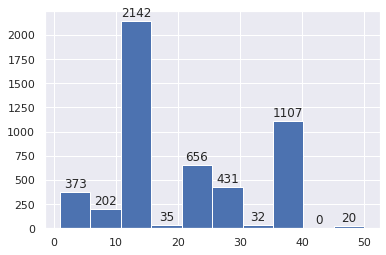

In [13]:
# 회사별로 데이터가 있는 기간이 다르다. (데이터 불균형)
# 가장 많은 것은 12개월(1771개), 38개월(809개), 24개월(579개)
# 따라서 직원수, 연매출액, 보험료 분포는 총합이 아닌 평균으로 구한다. 
sns.set_theme(style='darkgrid')
plots = df_count['연매출액'].hist()
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.show()

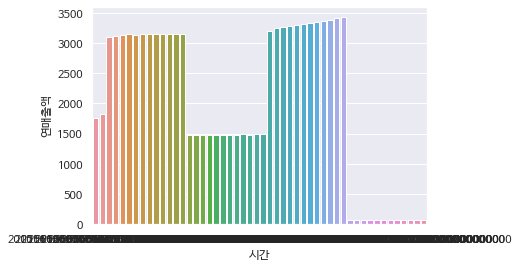

In [16]:
# 데이터 많이 있는 구간
df_count_time = df.groupby('시간').count().reset_index()
sns.barplot(data=df_count_time[['시간', '연매출액']], x='시간', y='연매출액');

In [ ]:
# 날짜 보이는 시각화
# 2016년, 2018년 데이터는 다수 있지만 2019년 데이터는 매우 적음

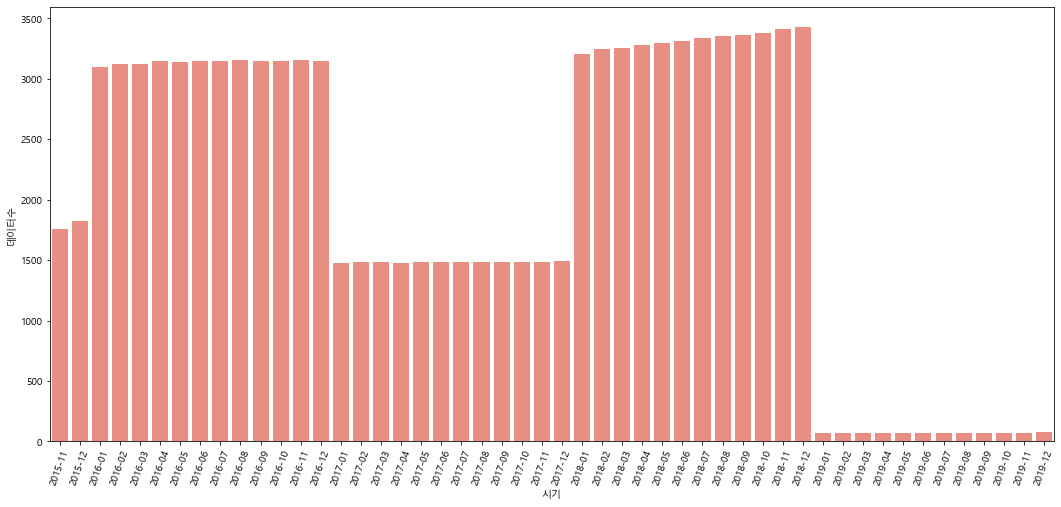

In [20]:
# 직원당 평균 연금을 추가하여 임금수준을 확인하는데 사용한다.
df['직원당_연금보험료'] = df['월별_연금보험료'] / df['월별_직원수']
df['직원당_매출'] = df['연매출액'] / df['월별_직원수']
df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,시간,직원당_연금보험료,직원당_매출
0,233757,41688077,2018,7,8912380,36,2018-07-01,247566.11111,1158002.13889
1,123464,1760695,2018,3,942380,5,2018-03-01,188476.00000,352139.00000
2,342124,3221341,2018,7,781180,4,2018-07-01,195295.00000,805335.25000
3,386420,4815584,2015,11,3795900,14,2015-11-01,271135.71429,343970.28571
4,129243,9799736,2018,10,40724680,151,2018-10-01,269699.86755,64898.91391


In [123]:
# 회사별 평균 구하기
df_groupby_id = df.groupby('회사ID').mean().reset_index()
df_groupby_id

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,직원당_연금보험료,직원당_매출
0,63,11328779396.00000,2018.00000,6.50000,410128228.33333,1007.16667,407239.46750,11248743.74219
1,95,656947437.00000,2018.00000,6.50000,214837843.33333,541.00000,397193.19895,1214751.56473
2,102,742658938.00000,2018.00000,8.50000,173769522.50000,752.12500,231111.80215,988296.81757
3,295,83776697.00000,2018.00000,8.50000,77312035.00000,259.50000,298169.58326,325635.98790
4,414,19732769.00000,2018.00000,6.50000,77590193.33333,247.58333,313382.16398,79704.21764
...,...,...,...,...,...,...,...,...
4993,2400284,1263406.00000,2018.00000,7.00000,1055497.14286,4.71429,219934.89796,296513.65306
4994,2437574,214016.00000,2018.00000,5.00000,636740.00000,3.00000,212246.66667,71338.66667
4995,2693684,238076.00000,2019.00000,9.50000,438120.00000,3.00000,146040.00000,79358.66667
4996,3312354,1451563.00000,2019.00000,10.00000,1312200.00000,3.00000,437400.00000,483854.33333


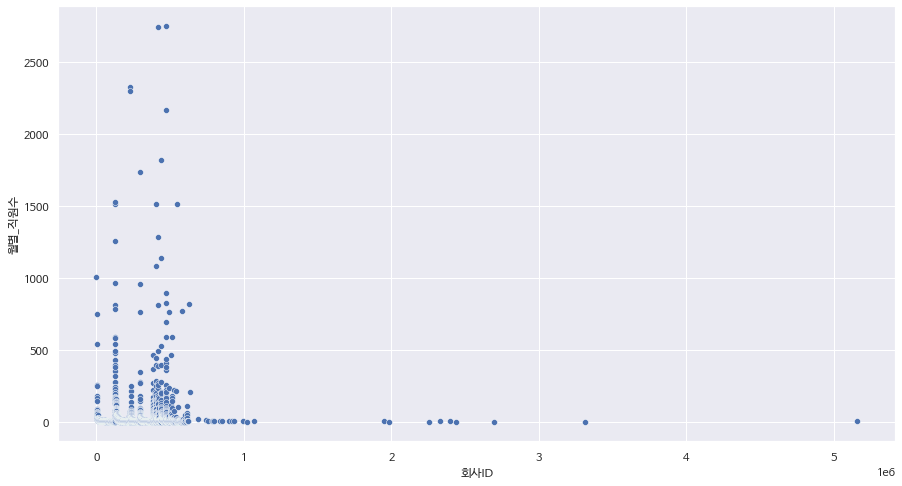

In [124]:
#회사별 50개월 간 직원 수 평균 분포
plt.figure(figsize = (15,8))
sns.scatterplot(data=df_groupby_id, x='회사ID', y='월별_직원수');

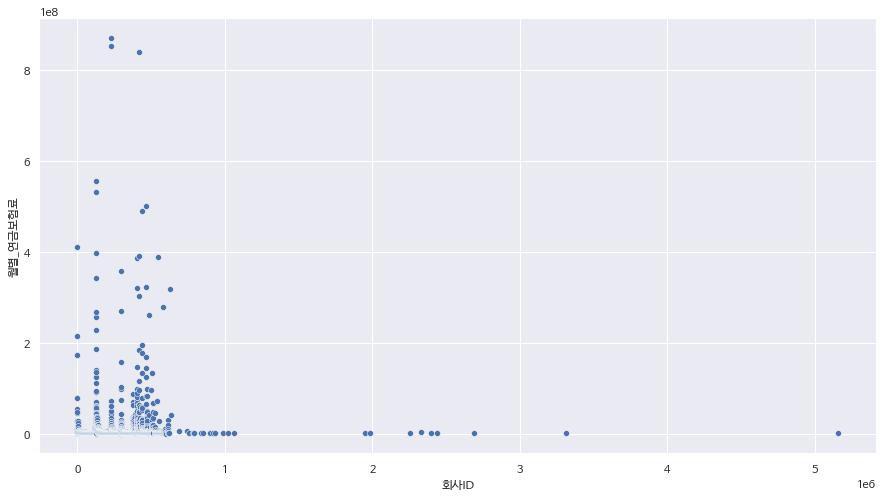

In [125]:
#회사별 50개월 간 연금보험료 평균 분포 (1e8 = 1억)
plt.figure(figsize = (15,8))
sns.scatterplot(data=df_groupby_id, x='회사ID', y='월별_연금보험료');

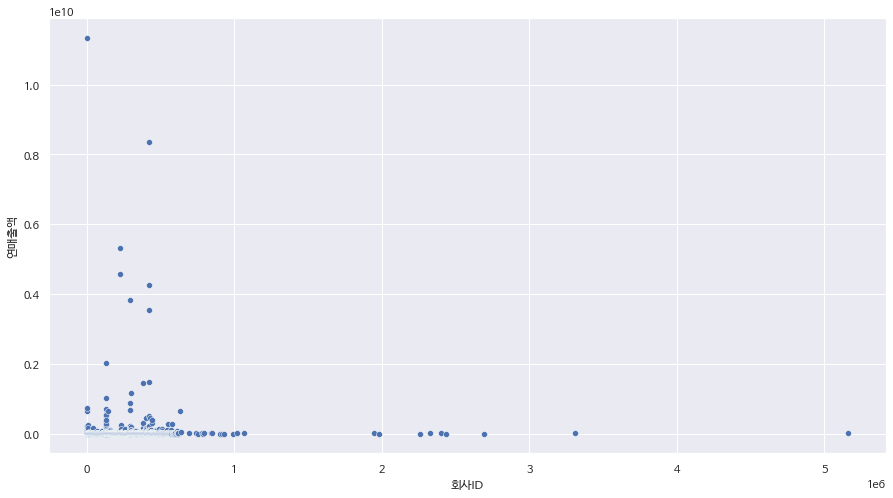

In [126]:
#회사별 5개년 연매출액 평균 분포 (1e10 = 10조)
plt.figure(figsize = (15,8))
sns.scatterplot(data=df_groupby_id, x='회사ID', y='연매출액');

#### 데이터간 상관관계 알아보기
- 회사별 평균 직원수, 연매출액, 연금보험료, 직원당 연금보험료 (임금과 연관)
- (가설) 직원수가 많을수록 매출액도 높을 것이다
- (가설) 직원수가 많을수록 연금보험료도 높을 것이다 (지출 상승)

In [22]:
# 필요없는 columns 삭제
df_groupby_id.drop(df_groupby_id[['회사ID','년도','월']], axis=1, inplace=True)
df_groupby_id

,연매출액,월별_연금보험료,월별_직원수,직원당_연금보험료,직원당_매출
0,11328779396.00000,410128228.33333,1007.16667,407239.46750,11248743.74219
1,656947437.00000,214837843.33333,541.00000,397193.19895,1214751.56473
2,742658938.00000,173769522.50000,752.12500,231111.80215,988296.81757
3,83776697.00000,77312035.00000,259.50000,298169.58326,325635.98790
4,19732769.00000,77590193.33333,247.58333,313382.16398,79704.21764
...,...,...,...,...,...
4993,1263406.00000,1055497.14286,4.71429,219934.89796,296513.65306
4994,214016.00000,636740.00000,3.00000,212246.66667,71338.66667
4995,238076.00000,438120.00000,3.00000,146040.00000,79358.66667
4996,1451563.00000,1312200.00000,3.00000,437400.00000,483854.33333


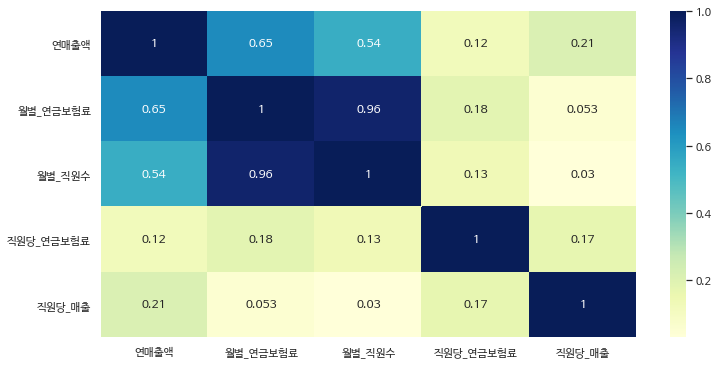

In [23]:
corr = df_groupby_id.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

1. 연금보험료와 직원수은 높은 양의 상관관계를 갖고 있음 (0.96)
2. 연금보험료와 연매출액은 어느 정도 양의 상관관계를 갖고 있지만, 높다고 할 수는 없음 (0.65)
3. 직원수와 매출액 또한 상관관계가 강하지 않음 (0.54)
4. 직원당 연금보험료와 매출은 다른 요인과 큰 관련 없음

#### 유니콘 기업은 상승률과 관계가 깊다. 회사별로 상승률 분포 확인하기
- 연 매출액은 1년 이하 데이터가 있는 기업이 많기 때문에 월별 데이터가 있는 칼럼만 확인
- 월별 연금보험료 증가량, 월별 직원수 증가량

In [74]:
#시간순으로 sort
df = df.sort_values('시간')

In [80]:
# 직원증가량 : (마지막년도 직원수 - 첫년도 직원수) / 첫년도 직원수 * 100
# 임금증가량 : (마지막년도 연금 - 첫년도 연금) / 첫년도 연금 * 100

df_growth = pd.DataFrame(columns=['회사ID','월별_연금보험료_증가량','월별_직원수_증가량'])
df_growth['회사ID'] = df.sort_values('회사ID')['회사ID'].unique()
for i in range(4998):
  last = df.groupby('회사ID').last().iloc[i]
  first = df.groupby('회사ID').first().iloc[i]
  df_growth['월별_연금보험료_증가량'].iloc[i] = round((last['월별_연금보험료'] - first['월별_연금보험료'])/first['월별_연금보험료'] * 100, 2)
  df_growth['월별_직원수_증가량'].iloc[i] = round((last['월별_직원수'] - first['월별_직원수'])/first['월별_직원수'] * 100, 2)
df_growth.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,회사ID,월별_연금보험료_증가량,월별_직원수_증가량
0,63,4.18000,0.80000
1,95,-4.03000,-7.12000
2,102,3.43000,6.23000
3,295,-22.55000,-19.05000
4,414,6.06000,-0.81000


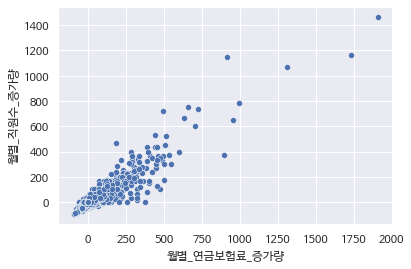

In [101]:
# 양의 상관관계가 나타난다
sns.scatterplot(data=df_growth, x='월별_연금보험료_증가량', y='월별_직원수_증가량');

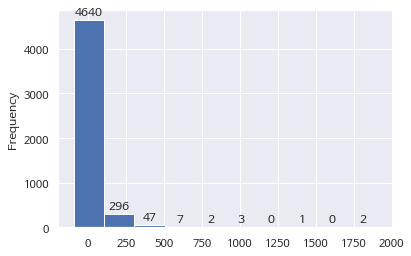

In [99]:
# 연금보험료의 경우
# 약간의 증가/감소량을 보이는 기업이 다수이며, 아웃라이어로 평가되는 기업들이 유니콘 기업일것

plots = df_growth['월별_연금보험료_증가량'].plot.hist();
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.show()

In [110]:
# 증가량 250% 이상인 기업만 잘라서 보기
# 47 + 7 + 2 + 3 + 1 + 2 = 62
df_over_250 = df_growth.sort_values('월별_연금보험료_증가량',ascending=False)[:62]
df_over_250

,회사ID,월별_연금보험료_증가량,월별_직원수_증가량
683,137755,1910.42000,1466.67000
20,3611,1733.11000,1166.67000
517,129633,1311.61000,1072.73000
3760,394749,992.50000,781.25000
2897,306768,952.44000,650.00000
...,...,...,...
134,36940,313.42000,233.33000
642,135559,311.34000,211.54000
3344,341803,307.53000,166.67000
3154,325410,307.38000,250.00000


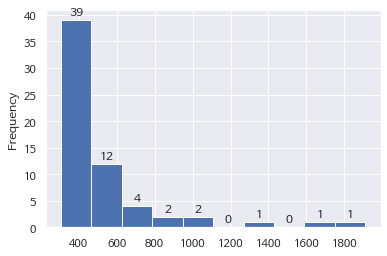

In [112]:
plots = df_over_250['월별_연금보험료_증가량'].plot.hist();
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.show()

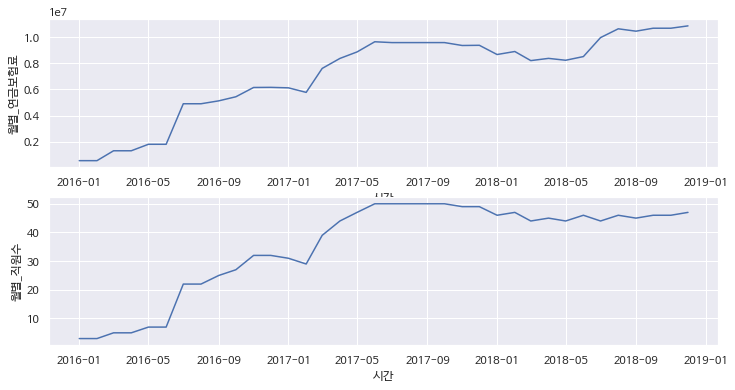

In [119]:
# 가장 크게 상승한 (1910%) 회사의 데이터 흐름 그려보기
# 거의 비슷한 것을 알 수 있다. 
max = df[df['회사ID']==137755]
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
sns.lineplot(data=max, x='시간', y='월별_연금보험료');
plt.subplot(2,1,2)
sns.lineplot(data=max, x='시간', y='월별_직원수');

#### EDA를 통해 얻은 결론
1. 연금보험료와 직원수는 높은 상관관계가 있지만, 연매출액과 연금보험료, 직원수는 상관관계가 높지 않다.
2. 1년 이하의 데이터를 가진 회사가 많다
3. 직원수가 적고, 연매출액이 적은 회사가 많다 (규모가 작다)

### 🤔 2. 유니콘 기업을 어떻게 정의할 것인가?

#### 💡 유니콘 기업의 의미 (위키백과)

    ✔ 기업가치 10억달러 (약 한화 1조원) 이상 
    ✔ 창업한지 10년 이내
    ✔ 비상장 스타트업


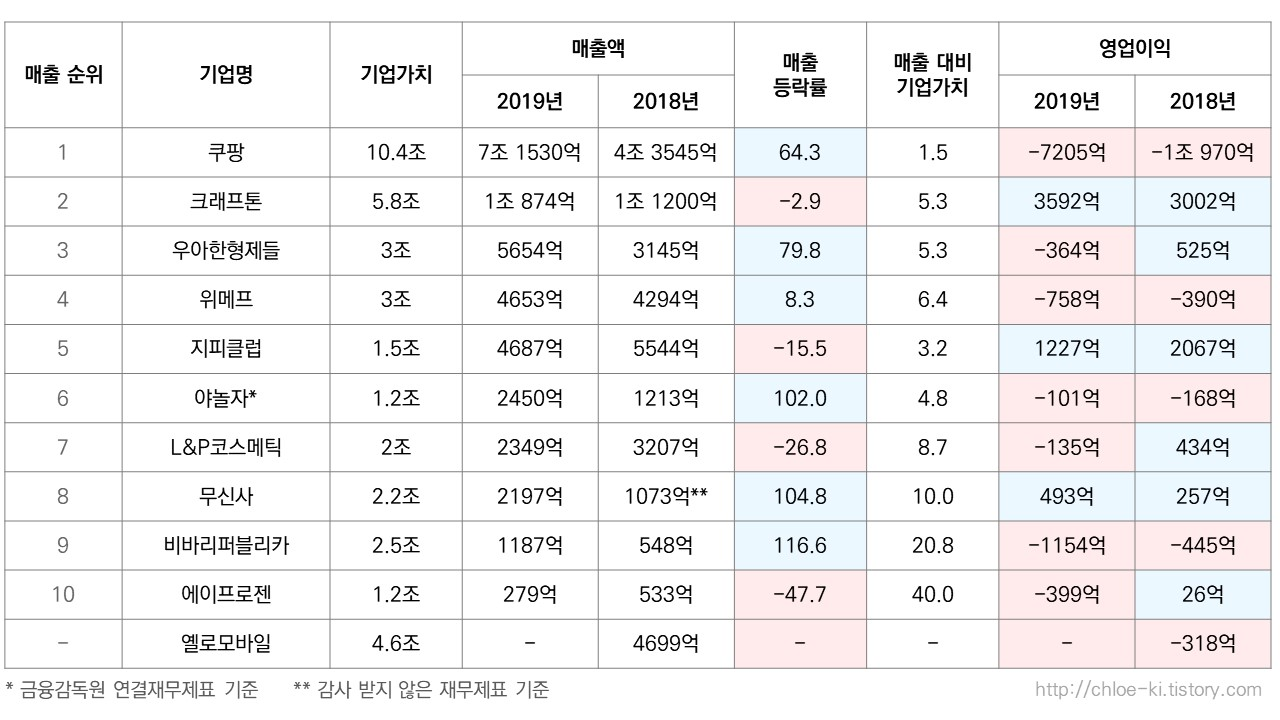

#### 💡 유니콘 기업의 특징

    ✔ 기업가치에 비해 매출액이 적다.
    ✔ 그래도 어느정도 규모는 있다. 여기서 규모는 매출, 직원수, 사업기간등을 포함한다. (국내 유니콘 기업기준 최소 매출 279억, 최소 직원수 153명)
    ✔ 규모가 제한적이다. (최대 매출 약 7조, 최대 직원수 약 9000명)
    ✔ 사업기간이 너무 길지도 짧지도 않다.
    ✔ 성장세가 가파른 구간이 있다.

#### 📈 유니콘 기업은 높은 성장세를 보일것이다?
|배민 매출|직원수|급여|
|:-:|:-:|:-:|
|<img src='./배민 매출.jpg' style='width:300px'>|<img src='./배민직원수.png' style='width:300px'>|<img src='./배민급여.png' style='width:300px'>
|무신사 매출|직원수|급여|
|<img src='./무신사매출.jpg' style='width:300px'>|<img src='./무신사직원수.png' style='width:300px'>|<img src='./무신사급여.png' style='width:300px'>
|티몬 매출|직원수|급여|
|<img src='./티몬매출.png' style='width:300px'>|<img src='./티몬직원수.png' style='width:300px'>|<img src='./티몬급여.png' style='width:300px'>
|위메프 매출|직원수|급여|
|<img src='./위메프매출.jpg' style='width:300px'>|<img src='./위메프직원수.png' style='width:300px'>|<img src='./위메프급여.png' style='width:300px'>


    ✔ 배민, 무신사 등 다수의 유니콘 기업이 매출, 직원수, 급여 면에서 급격한 성장을 보여준다.
    ✔ 반면 티몬, 위메프, 옐로모바일 등 몇개의 기업은 오히려 거품빠지면서 급격히 성장세가 꺾이는 모습을 보여주며 오히려 규모가 작아지거나 유지한다.

### 📝 3. 데이터 분석

개요
1. 적당한 규모에 해당하는 기업을 필터링 한다.
  - 매출 250억 초과 (에이프로젠의 최소 매출)
  - 매출 8조 미만 (쿠팡 최대 매출)
  - 직원수 150명 초과 (지피클럽, 엘엔피코스매틱)
  - 데이터 24개월 이상 (연매출의 성장세를 보기 위해)
  
2. 필터링된 기업들의 성장세를 국내 유니콘 기업의 성장세와 비교하여 유사한 기업을 찾는다.

#### 데이터 필터링

In [133]:
# 가장 최근의 규모 기준으로 필터링
data_group = df.groupby(['회사ID']).last()
data_group_count = df.groupby(['회사ID']).count()
over_list = data_group[(data_group['연매출액'] > 25000000) & (data_group['월별_직원수'] > 150) & 
                       (data_group_count['연매출액'] >= 24) & (data_group['연매출액'] < 8000000000)].index.unique()
print(over_list)
print(len(over_list))

Int64Index([126516, 126521, 126538, 126606, 126664, 126674, 126772, 126802,
            126814, 126831, 126983, 127060, 127065, 127090, 127142, 127180,
            127366, 127503, 127511, 127669, 127732, 127839, 128076, 128149,
            128264, 128405, 128415, 128440, 128485, 128539, 128638, 128723,
            128916, 227414, 227415, 231080, 231090, 231173, 294337, 294367,
            294387, 294530, 294620, 294649, 294790, 380843, 381180, 394696,
            394723, 403351, 403359, 403434, 403462, 403470, 403504, 403522,
            403657, 403771, 419977, 419998, 420008, 420046, 420076, 420082,
            420147, 420165, 426429, 440030, 440094, 469458, 469473, 469556,
            469567, 469677, 470125, 510329],
           dtype='int64', name='회사ID')
76


#### ∴ 필터링 된 기업 개수는 총 76개이다.

In [139]:
# 참고) 연금보험료 상승률 250% 이상 기업들 리스트와 비교하면 다음 2개의 기업이 겹침
List1 = list(df_over_250['회사ID'])
List2 = over_list

for i in List1 :
    if i in List2 :
        print("List 2 containing :")
        print(i)

List 2 containing :
380843
List 2 containing :
403470


#### 급격한 상승세가 발생하는 기업을 찾자

In [141]:
data = pd.DataFrame(index=over_list, columns=['년수', '매출증가량', '직원증가량', '임금증가량', '직원당매출증가량', '매출증가량평균(절댓값)'], dtype=float)

# 매출증가량 : (마지막년도 매출 - 첫년도 매출) / 첫년도 매출 * 100
# 직원증가량 : (마지막년도 직원수 - 첫년도 직원수) / 첫년도 직원수 * 100
# 임금증가량 : (마지막년도 연금 - 첫년도 연금) / 첫년도 연금 * 100
# 매출증가량평균(절댓값) : 매년 매출증가량의 절댓값 합을 년수로 나눔. 티몬같이 매출이 급격히 증가하고 감소한 경우를 잡기 위해 추가함.

for id in over_list:
    temp = df[df['회사ID'] == id]

    first = temp.iloc[0, :]
    last = temp.iloc[-1, :]
    
    sales = temp.연매출액.unique()
    sales_growth = 0 # 매출 변화량 절댓값의 평균
    for idx in range(len(sales)-1):
#         print(sales[idx+1], sales[idx])
        sales_growth += abs( (sales[idx+1] - sales[idx]) / sales[idx] * 100 )
    
    #print(id, '기업')
    #print(last.년도 - first.년도, '년간','매출증가량 : ', round((last.연매출액 - first.연매출액) / first.연매출액 * 100.0, 2))
    #print('직원증가량 : ', round((last.월별_직원수 - first.월별_직원수) / first.월별_직원수 * 100.0, 2))
    #print('임금증가량 : ', round((last.직원당_연금보험료 - first.직원당_연금보험료) / first.직원당_연금보험료 * 100.0,2))
    #print('직원당매출증가량 : ', round((last.직원당_매출 - first.직원당_매출) / first.직원당_매출 * 100.0,2))
    #print('매출증가량평균(절댓값) : ', round(sales_growth, 2))
    #print('--------------------------------------------------------')
    
    data.loc[id, :] = [last.년도 - first.년도, round((last.연매출액 - first.연매출액) / first.연매출액 * 100.0, 2), 
                      round((last.월별_직원수 - first.월별_직원수) / first.월별_직원수 * 100.0, 2), 
                      round((last.직원당_연금보험료 - first.직원당_연금보험료) / first.직원당_연금보험료 * 100.0,2),
                      round((last.직원당_매출 - first.직원당_매출) / first.직원당_매출 * 100.0,2),
                      round(sales_growth/ (last.년도 - first.년도), 2)]

In [157]:
data

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값)
회사ID,,,,,,
126516,2.00000,-62.08000,-55.44000,7.70000,-14.91000,34.99000
126521,3.00000,-0.12000,-6.30000,9.50000,6.60000,1.53000
126538,3.00000,19.25000,9.26000,11.65000,9.14000,6.13000
126606,3.00000,10.51000,-2.81000,13.04000,13.70000,3.41000
126664,3.00000,37.95000,18.11000,9.20000,16.80000,11.44000
...,...,...,...,...,...,...
469556,3.00000,-2.08000,-5.16000,22.53000,3.25000,10.76000
469567,2.00000,22.73000,-36.43000,43.18000,93.07000,13.49000
469677,3.00000,122.16000,64.76000,-0.49000,34.84000,30.63000


In [158]:
data.sort_values('매출증가량평균(절댓값)', ascending=False)

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값)
회사ID,,,,,,
294620,3.00000,1419.82000,7.48000,8.65000,1314.05000,482.02000
294790,3.00000,-39.23000,-3.08000,29.94000,-37.30000,115.64000
403470,3.00000,398.90000,520.90000,-0.80000,-19.65000,83.17000
127366,3.00000,270.90000,29.92000,6.43000,185.49000,62.37000
294337,3.00000,179.91000,87.85000,6.57000,49.01000,41.12000
...,...,...,...,...,...,...
419977,2.00000,-4.09000,-12.17000,20.96000,9.20000,2.07000
128076,3.00000,6.09000,5.26000,18.39000,0.79000,1.99000
419998,2.00000,-0.14000,3.44000,11.14000,-3.46000,1.97000


#### 유니콘 기업의 특징

    - 미래 성장가치가 기업가치에 투영되어 매출이 절대적으로 중요한 요소는 아니다.
    - 하지만 매출의 성장세는 성장가치가 유효한지 판단하는 근거이므로 기업가치에 중요한 요소이다.
    - 지금까지 성장하는 모습만 보여준 기업도 있지만 급격히 하락세를 겪는 기업도 존재한다.


    여기서 케이스 분류를 해볼 수 있다.
    1. 매출 증가, 규모 확대 : 유니콘일수도 아닐수도
    2. 매출 증가, 규모 축소 : 유니콘이 아니다. (성장세를 이어가야하기 때문)
    3. 매출 감소, 규모 확대 : 유니콘이 아니다. (하락세일 경우 투자자금이 준다.)
    4. 매출 감소, 규모 축소 : 유니콘일수도 아닐수도

In [159]:
def case(data):
    if data['매출증가량'] > 0:
        if data['직원증가량'] + data['임금증가량'] > 0:
            return 1
        else:
            return 2
    else :
        if data['직원증가량'] + data['임금증가량'] > 0:
            return 3
        else:
            return 4

In [160]:
data['케이스'] = data.apply(case, axis=1)
data

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
126516,2.00000,-62.08000,-55.44000,7.70000,-14.91000,34.99000,4
126521,3.00000,-0.12000,-6.30000,9.50000,6.60000,1.53000,3
126538,3.00000,19.25000,9.26000,11.65000,9.14000,6.13000,1
126606,3.00000,10.51000,-2.81000,13.04000,13.70000,3.41000,1
126664,3.00000,37.95000,18.11000,9.20000,16.80000,11.44000,1
...,...,...,...,...,...,...,...
469556,3.00000,-2.08000,-5.16000,22.53000,3.25000,10.76000,3
469567,2.00000,22.73000,-36.43000,43.18000,93.07000,13.49000,1
469677,3.00000,122.16000,64.76000,-0.49000,34.84000,30.63000,1


In [161]:
data.케이스.value_counts()

1    53
3    17
4     4
2     2
Name: 케이스, dtype: int64

In [162]:
# 해당하는 경우는 총 57개
case_list = data[(data['케이스'] == 1) | (data['케이스'] == 4)].index
len(case_list)

57

In [164]:
# 급격한 변화량을 보이는 경우 19개
last_list = data[(data.index.isin(case_list)) & (data['매출증가량평균(절댓값)'] > 20)].index
len(last_list)

19

In [165]:
def draw_graphs(data):
    rcParams['figure.figsize'] = 16,4
    plt.subplot(1,3,1)
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title('연매출')
    ax = sns.lineplot(data=data.set_index('시간')['연매출액'])
    plt.xticks(rotation="45")

    plt.subplot(1,3,2)
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title('직원수')
    ax = sns.lineplot(data=data.set_index('시간')['월별_직원수'])
    plt.xticks(rotation="45")
    
    plt.subplot(1,3,3)
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title('임금')
    ax = sns.lineplot(data=data.set_index('시간')['직원당_연금보험료'])
    plt.xticks(rotation="45")
    
    plt.show()

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
126516,2.00000,-62.08000,-55.44000,7.70000,-14.91000,34.99000,4


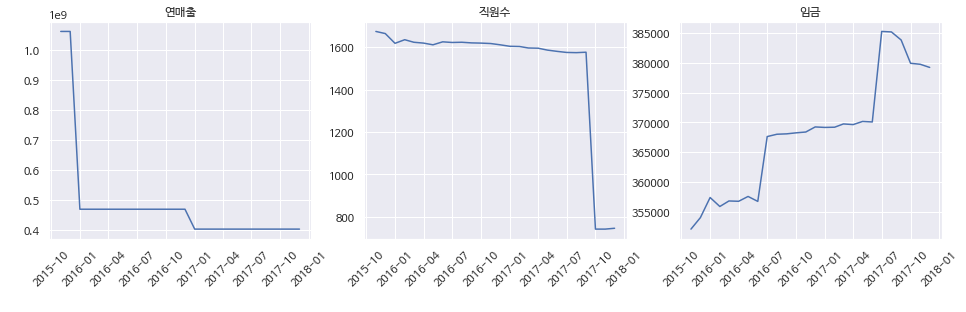

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
126802,3.00000,44.34000,52.67000,17.00000,-5.46000,38.85000,1


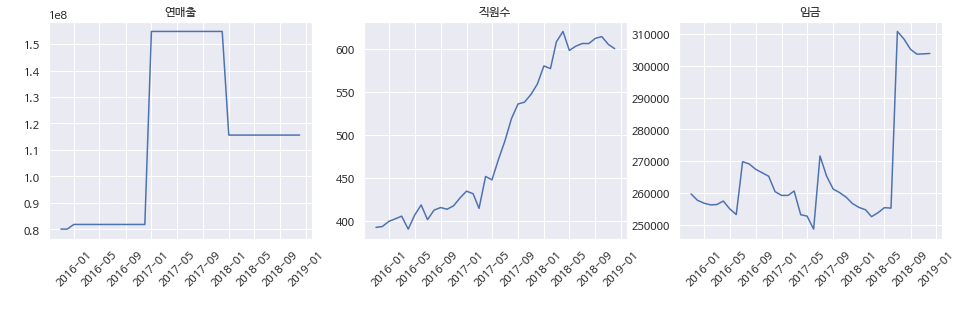

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
126814,3.00000,48.91000,4.76000,16.71000,42.14000,20.76000,1


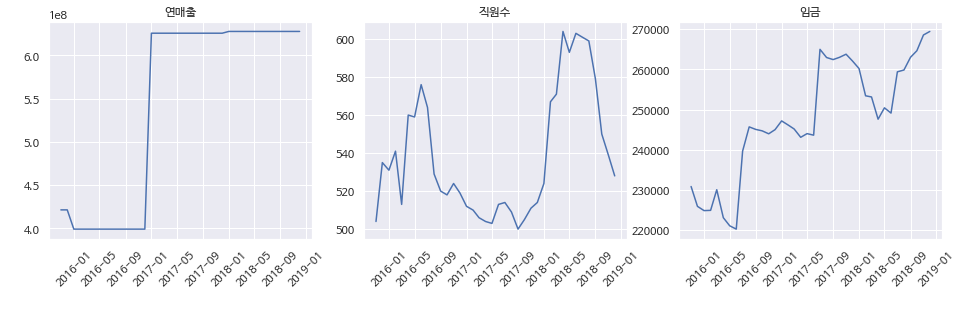

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
127090,3.00000,50.33000,-4.50000,12.50000,57.41000,31.78000,1


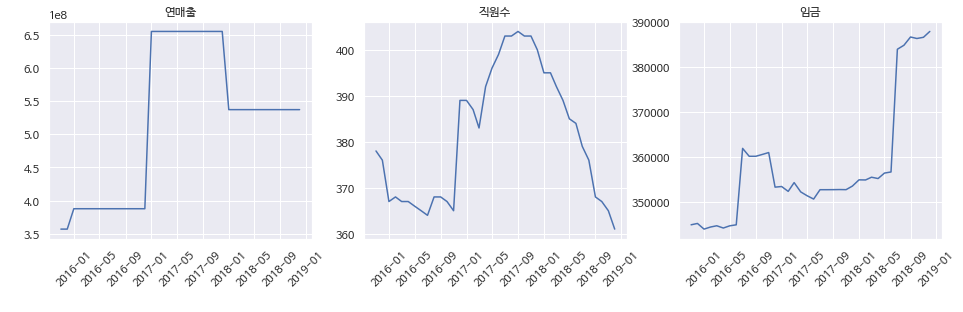

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
127366,3.00000,270.90000,29.92000,6.43000,185.49000,62.37000,1


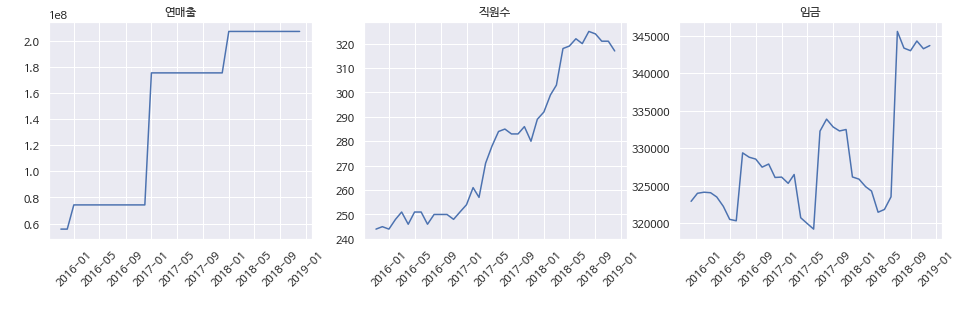

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
128264,3.00000,71.57000,7.69000,15.15000,59.31000,20.74000,1


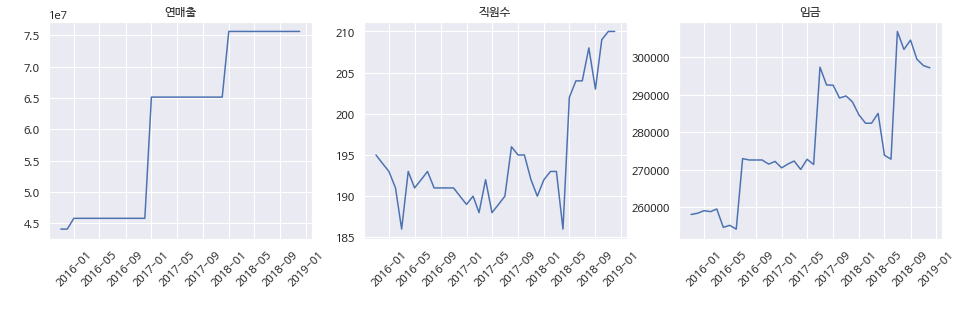

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
128405,3.00000,160.01000,37.14000,5.26000,89.59000,38.46000,1


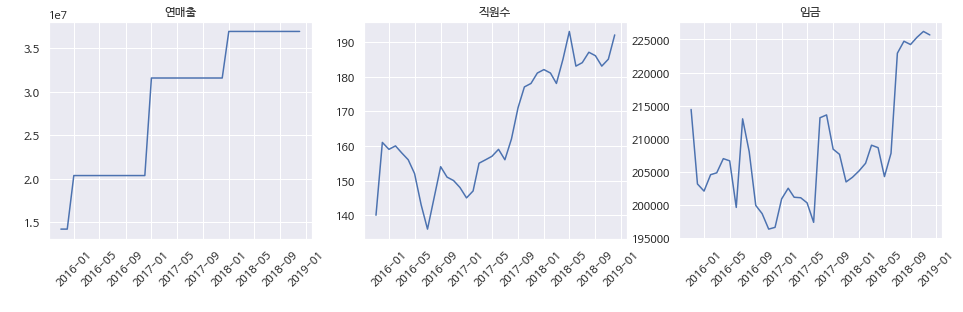

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
231090,3.00000,106.70000,24.87000,7.39000,65.53000,30.15000,1


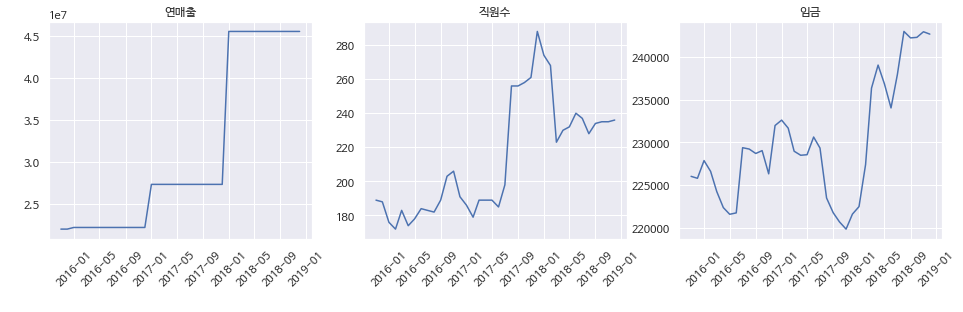

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
231173,3.00000,-17.39000,-15.62000,12.35000,-2.09000,28.95000,4


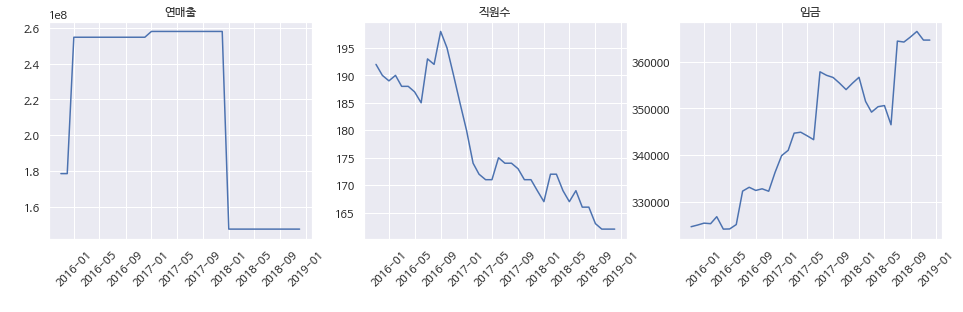

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
294337,3.00000,179.91000,87.85000,6.57000,49.01000,41.12000,1


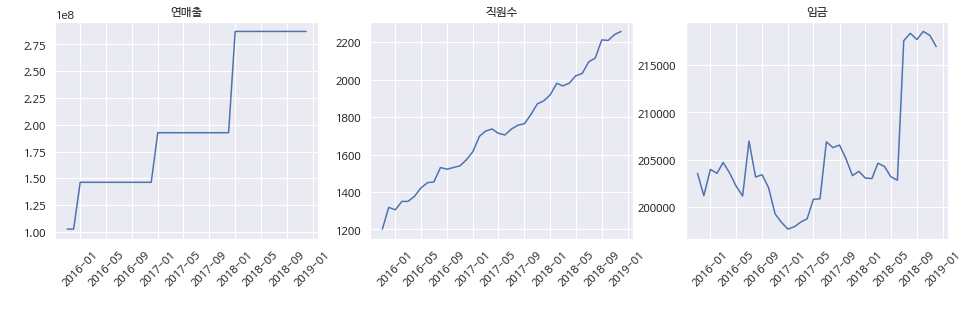

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
294620,3.00000,1419.82000,7.48000,8.65000,1314.05000,482.02000,1


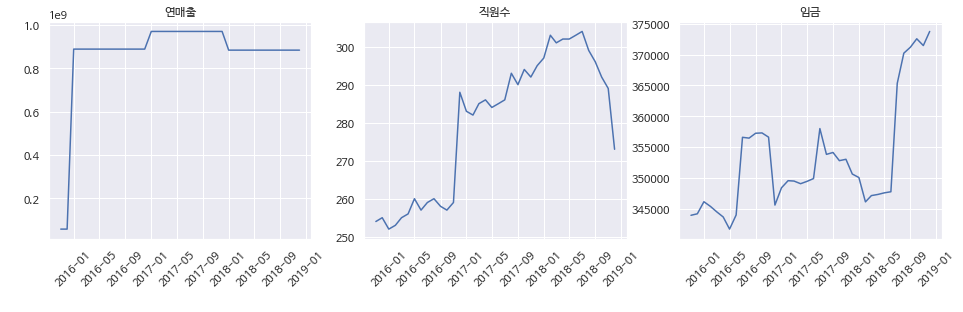

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
380843,2.00000,46.82000,1147.52000,-18.65000,-88.23000,23.41000,1


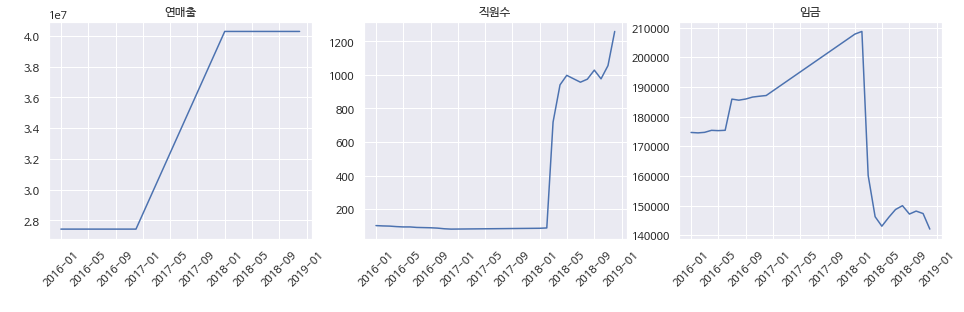

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
403470,3.00000,398.90000,520.90000,-0.80000,-19.65000,83.17000,1


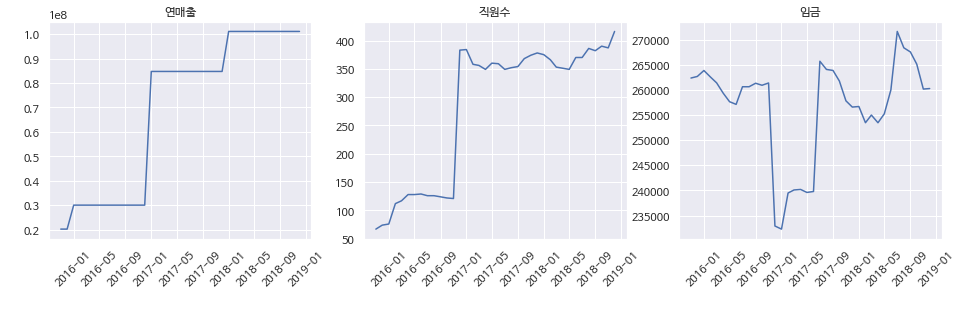

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
403522,2.00000,-39.50000,-27.95000,3.70000,-16.03000,21.97000,4


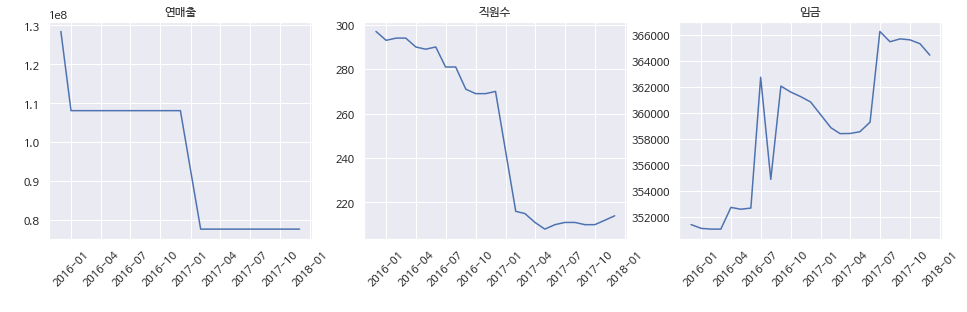

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
420046,2.00000,53.33000,15.20000,7.77000,33.10000,23.83000,1


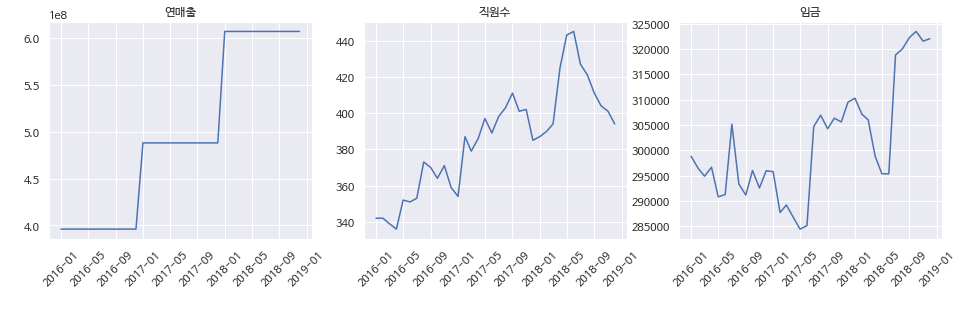

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
420165,3.00000,108.76000,26.62000,17.61000,64.86000,31.79000,1


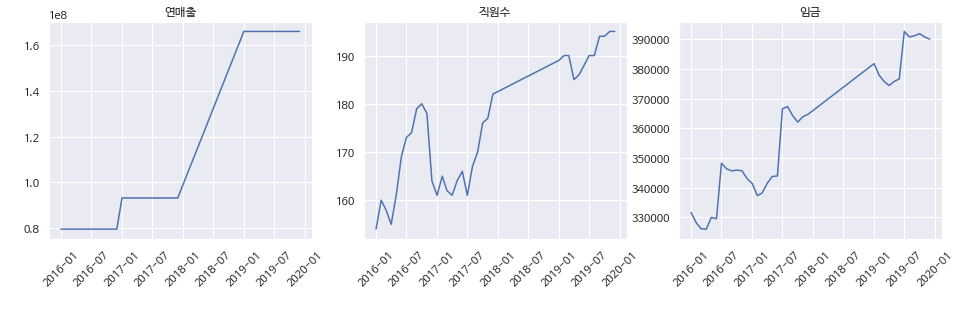

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
440094,3.00000,116.46000,110.11000,27.79000,3.02000,29.45000,1


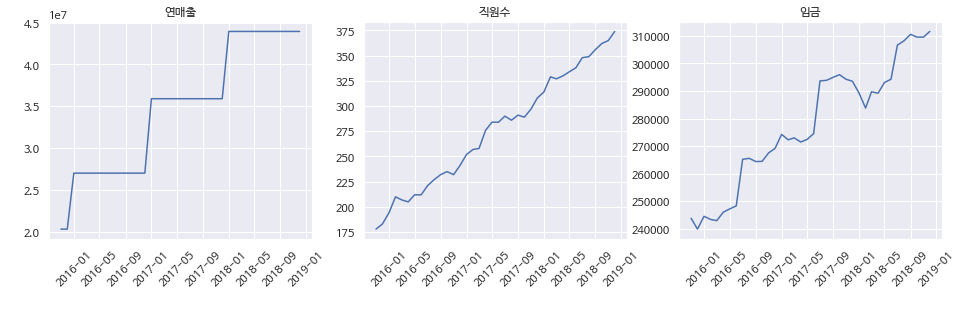

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
469677,3.00000,122.16000,64.76000,-0.49000,34.84000,30.63000,1


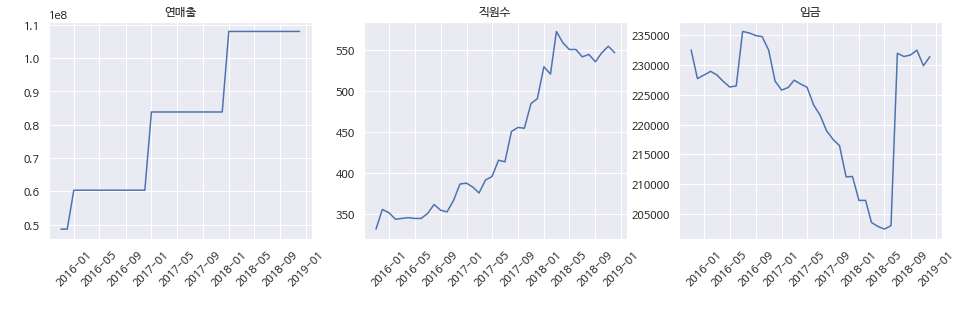

,년수,매출증가량,직원증가량,임금증가량,직원당매출증가량,매출증가량평균(절댓값),케이스
회사ID,,,,,,,
470125,3.00000,87.12000,13.73000,22.92000,64.54000,24.19000,1


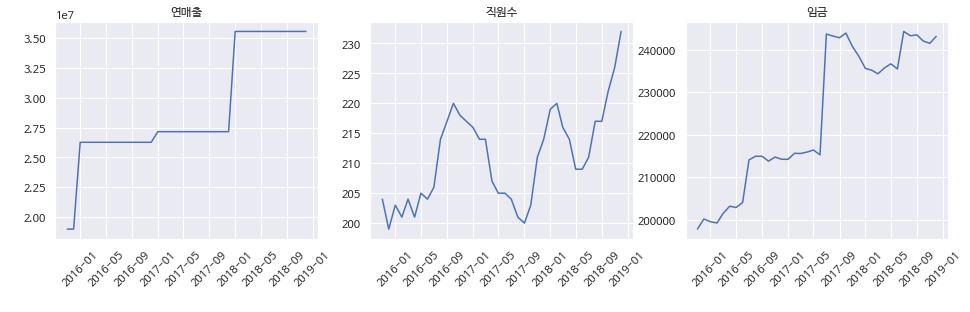

In [167]:
for id in last_list:
    
    display(data[data.index == id])
    draw_graphs(df[df['회사ID'] == id])

### 🧑🏻‍💻 4. 결론

- 위의 시각화 그래프에서 다음의 경우를 제외하였습니다

1. 17년 이전에 매출 하락이 발생한 경우 (126516, 403522)
2. 폭발적인 성장세를 보이지 못하고 변화가 더딘 경우 (126814, 231173, 294620, 470125)
3. 매출과 규모의 추세가 반대되는 경우 (126802)
  
---
  
#### 따라서 🦄 기업은  
127090, 127366, 128264, 128405, 231090, 294337, 380843, 403470, 420046, 420165, 440094, 469677
- 총 12개의 기업을 선정하였습니다.